In [2]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn
import os

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")
PATH = "gdrive/My Drive/Comp 4211/pa3/"

Mounted at /content/gdrive/


In [4]:
train_path = os.path.join(PATH, "train.csv")
all_train = pd.read_csv(train_path)
test_path = os.path.join(PATH, "test.csv")
test = pd.read_csv(test_path)
print(all_train.shape)
all_train.head()

(12375, 2)


,label,text
0,0,"Toots Thielemans, Who Won Jazz Renown With the..."
1,0,‘The Greatest Loss and Despair’: Thais Mourn T...
2,0,George Will Leaves the G.O.P. Over Donald Trump
3,0,Rafael Nadal Upset by Lucas Pouille in Fourth ...
4,0,"Hollywood Holiday Habits: Big Games, Small Gif..."


In [5]:
from sklearn.model_selection import train_test_split
all_train_0 = all_train[all_train["label"] == 0]
all_train_1 = all_train[all_train["label"] == 1]
train_0, valid_0 = train_test_split(all_train_0, test_size = 1000, random_state = 4211)
train_1, valid_1 = train_test_split(all_train_1, test_size = 1000, random_state = 4211)

In [6]:
train_path = os.path.join(PATH, "train_train.csv")
valid_path = os.path.join(PATH, "train_valid.csv")
train_0.to_csv(train_path, index = False)
train_1.to_csv(train_path, mode = "a", header = False, index = False)
valid_0.to_csv(valid_path, index = False)
valid_1.to_csv(valid_path, mode = "a", header = False, index = False)

In [7]:
!pip install -U torchtext==0.8.0

     |████████████████████████████████| 7.0MB 13.8MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [9]:
from torchtext.data import Field, TabularDataset, BucketIterator

import nltk
nltk.download("punkt")
from nltk import word_tokenize

txt_field = Field(tokenize = word_tokenize, lower = True, batch_first = True, include_lengths = True) # "i like the moive" -> "i", "like", "the", "movie"
label_field = Field(sequential = False, use_vocab = False, batch_first = True) #0, 1

# make splits for data
train_data, valid_data = TabularDataset.splits(path = PATH, train = "train_train.csv", test = "train_valid.csv", format = "csv", 
                                  fields=[("label", label_field), ("text", txt_field)], skip_header = True)

# build the vocabulary on the training set only, 
txt_field.build_vocab(train_data, min_freq = 2) 
#txt_field.build_vocab(valid_data, min_freq = 2)
#label_field.build_vocab(train)

# make iterator for splits
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data), batch_size = 64, sort_key = lambda x: len(x.text), sort_within_batch = True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [10]:
oov = 0
train_vocabulary = []
for ex in train_data.examples:
  for vocabulary in ex.text:
    if (vocabulary in train_vocabulary):
      continue
    else:
      train_vocabulary.append(vocabulary)
for vocabulary in train_vocabulary:
  if (txt_field.vocab.freqs[vocabulary] < 2):
    oov = oov + 1
  else:
    oov = oov
print(oov)

8650


In [11]:
oov = 0
valid_vocabulary = []
for ex in valid_data.examples:
  for vocabulary in ex.text:
    if (vocabulary in valid_vocabulary):
      continue
    else:
      valid_vocabulary.append(vocabulary)
for vocabulary in valid_vocabulary:
  if (txt_field.vocab.freqs[vocabulary] < 2):
    oov = oov + 1
  else:
    oov = oov
print(oov)

2740


In [12]:
import torch.nn as nn
class baseline_model(nn.Module):
    def __init__(self, n_vocab, embedding_dim):
        super(baseline_model, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.RNN(
                input_size = embedding_dim,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [13]:
!pip install torchsummaryX
from torchsummaryX import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_vocab = len(txt_field.vocab)
model = baseline_model(n_vocab, 50).cuda()
summary(model, torch.zeros((64, 12), dtype = torch.long).cuda())

cuda
         Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                 
0_emb      [50, 7953]  [64, 12, 50]  397.65k   397.65k
1_rnn               -  [64, 12, 64]   7.424k    7.296k
2_drop              -      [64, 64]        -         -
3_linear      [64, 1]       [64, 1]     65.0      64.0
--------------------------------------------------------
                        Totals
Total params          405.139k
Trainable params      405.139k
Non-trainable params       0.0
Mult-Adds              405.01k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_emb,"[50, 7953]","[64, 12, 50]",397650.0,397650.0
1_rnn,-,"[64, 12, 64]",7424.0,7296.0
2_drop,-,"[64, 64]",NaN,NaN
3_linear,"[64, 1]","[64, 1]",65.0,64.0


In [23]:
def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_acc': val_acc}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_acc']
    print(f'Model loaded from {save_path}, with val accuracy: {val_acc}')
    return val_acc


def TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, val_acc, device, save_name):
    
    train_loss_record = []
    valid_loss_record = []
    
    if val_acc==None:
        best_val_acc = float(0)  
    else: 
        best_val_acc=val_acc
        print('Resume training')
    
    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        train_correct = 0
        #for i, (input, label) in enumerate(train_loader):
        for b in train_loader:
          text, text_len = b.text
          input = text
          input = input.to(device)
          label = b.label
          label = label.to(torch.float32)
          label = label.to(device)

          '''Training of the model'''
          # Forward pass
          output = model(input)
          output = torch.squeeze(output, 1)
          loss = criterion(output, label)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          output = (output > 0.5)
          train_correct = train_correct + torch.sum(output == label.data)

          
          

        train_loss = running_loss / len(train_loader)
        train_loss_record.append(train_loss)

        train_accuracy = train_correct / float(len(train_loader.dataset))

        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            valid_correct = 0
            #for i, (input, label) in enumerate(valid_loader):
            for b in valid_loader:
              text, text_len = b.text
              input = text
              input = input.to(device)
              label = b.label
              label = label.to(torch.float32)
              label = label.to(device)                

              # Forward pass
              output = model(input)
              output = torch.squeeze(output, 1)
              loss = criterion(output, label)

              running_loss += loss.item()

              output = (output > 0.5)
              
              valid_correct = valid_correct + torch.sum(output == label.data)
          

              

            val_loss = running_loss / len(valid_loader)
            valid_loss_record.append(val_loss)

            valid_accuracy = valid_correct / float(len(valid_loader.dataset))

            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Accuracy: {:.4f}' 
                  .format(epoch+1, num_epochs, train_loss, val_loss, train_accuracy, valid_accuracy))
            
            

            if valid_accuracy > best_val_acc:
                best_val_acc = valid_accuracy
                save_checkpoint(save_name, model, optimizer, best_val_acc)
                    
    print('Finished Training')
    return train_loss_record, valid_loss_record

In [29]:
from torch.optim import Adam

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

n_epochs = 15
val_acc = None
#save_name = 'rnn_model'
save_path = os.path.join(PATH, "rnn_model")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model.parameters())
#start training
train_loss_record, valid_loss_record = TRAIN(model, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4910, Valid Loss: 0.8419, Train Accuracy: 0.8078, Valid Accuracy: 0.5315
Model saved to gdrive/My Drive/Comp 4211/pa3/rnn_model
Epoch [2/15], Train Loss: 0.4240, Valid Loss: 0.6633, Train Accuracy: 0.8245, Valid Accuracy: 0.5940
Model saved to gdrive/My Drive/Comp 4211/pa3/rnn_model
Epoch [3/15], Train Loss: 0.3799, Valid Loss: 0.6813, Train Accuracy: 0.8492, Valid Accuracy: 0.6240
Model saved to gdrive/My Drive/Comp 4211/pa3/rnn_model
Epoch [4/15], Train Loss: 0.3326, Valid Loss: 0.6893, Train Accuracy: 0.8681, Valid Accuracy: 0.6675
Model saved to gdrive/My Drive/Comp 4211/pa3/rnn_model
Epoch [5/15], Train Loss: 0.2878, Valid Loss: 0.6829, Train Accuracy: 0.8904, Valid Accuracy: 0.6750
Model saved to gdrive/My Drive/Comp 4211/pa3/rnn_model
Epoch [6/15], Train Loss: 0.2460, Valid Loss: 0.5475, Train Accuracy: 0.9079, Valid Accuracy: 0.7160
Model saved to gdrive/My Drive/Comp 4211/pa3/rnn_model
Epoch [7/15], Train Loss: 0.2144, Valid Loss: 0.6461, Train Accu

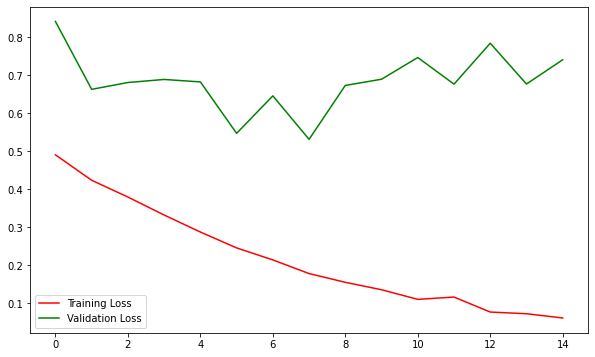

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record, c='red', label="Training Loss")
plt.plot(valid_loss_record, c='green', label="Validation Loss")
plt.legend()
plt.show()

In [31]:
class baseline_model_GRU(nn.Module):
    def __init__(self, n_vocab, embedding_dim):
        super(baseline_model_GRU, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.GRU(
                input_size = embedding_dim,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [32]:
n_epochs = 15
val_acc = None
model_GRU = baseline_model_GRU(n_vocab, 50).cuda()
save_path = os.path.join(PATH, "gru_model")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model_GRU.parameters())
#start training
train_loss_record_GRU, valid_loss_record_GRU = TRAIN(model_GRU, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4818, Valid Loss: 0.6952, Train Accuracy: 0.8075, Valid Accuracy: 0.5310
Model saved to gdrive/My Drive/Comp 4211/pa3/gru_model
Epoch [2/15], Train Loss: 0.3958, Valid Loss: 0.6029, Train Accuracy: 0.8279, Valid Accuracy: 0.6340
Model saved to gdrive/My Drive/Comp 4211/pa3/gru_model
Epoch [3/15], Train Loss: 0.3306, Valid Loss: 0.6219, Train Accuracy: 0.8618, Valid Accuracy: 0.6775
Model saved to gdrive/My Drive/Comp 4211/pa3/gru_model
Epoch [4/15], Train Loss: 0.2633, Valid Loss: 0.5425, Train Accuracy: 0.8942, Valid Accuracy: 0.7310
Model saved to gdrive/My Drive/Comp 4211/pa3/gru_model
Epoch [5/15], Train Loss: 0.2174, Valid Loss: 0.5364, Train Accuracy: 0.9160, Valid Accuracy: 0.7395
Model saved to gdrive/My Drive/Comp 4211/pa3/gru_model
Epoch [6/15], Train Loss: 0.1728, Valid Loss: 0.5744, Train Accuracy: 0.9322, Valid Accuracy: 0.7665
Model saved to gdrive/My Drive/Comp 4211/pa3/gru_model
Epoch [7/15], Train Loss: 0.1372, Valid Loss: 0.5797, Train Accu

In [33]:
class baseline_model_LSTM(nn.Module):
    def __init__(self, n_vocab, embedding_dim):
        super(baseline_model_LSTM, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [34]:
n_epochs = 15
val_acc = None
model_LSTM = baseline_model_LSTM(n_vocab, 50).cuda()
save_path = os.path.join(PATH, "lstm_model")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model_LSTM.parameters())
#start training
train_loss_record_LSTM, valid_loss_record_LSTM = TRAIN(model_LSTM, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4967, Valid Loss: 0.6685, Train Accuracy: 0.8072, Valid Accuracy: 0.5005
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model
Epoch [2/15], Train Loss: 0.3969, Valid Loss: 0.6736, Train Accuracy: 0.8210, Valid Accuracy: 0.5870
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model
Epoch [3/15], Train Loss: 0.3369, Valid Loss: 0.5182, Train Accuracy: 0.8596, Valid Accuracy: 0.7240
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model
Epoch [4/15], Train Loss: 0.2768, Valid Loss: 0.4892, Train Accuracy: 0.8852, Valid Accuracy: 0.7680
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model
Epoch [5/15], Train Loss: 0.2258, Valid Loss: 0.4989, Train Accuracy: 0.9087, Valid Accuracy: 0.7715
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model
Epoch [6/15], Train Loss: 0.1854, Valid Loss: 0.5399, Train Accuracy: 0.9282, Valid Accuracy: 0.7705
Epoch [7/15], Train Loss: 0.1681, Valid Loss: 0.5991, Train Accuracy: 0.9339, Valid Accuracy: 0.7290
Epoch [8/15],

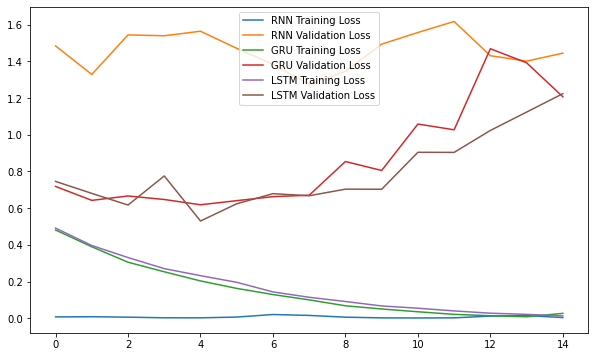

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record, label="RNN Training Loss")
plt.plot(valid_loss_record, label="RNN Validation Loss")
plt.plot(train_loss_record_GRU, label="GRU Training Loss")
plt.plot(valid_loss_record_GRU, label="GRU Validation Loss")
plt.plot(train_loss_record_LSTM, label="LSTM Training Loss")
plt.plot(valid_loss_record_LSTM, label="LSTM Validation Loss")
plt.legend()
plt.show()

In [27]:
class baseline_model_LSTM_Bidirectional(nn.Module):
    def __init__(self, n_vocab, embedding_dim):
        super(baseline_model_LSTM_Bidirectional, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True,
                bidirectional = True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(128, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [28]:
n_epochs = 15
val_acc = None
model_LSTM_Bidirectional = baseline_model_LSTM_Bidirectional(n_vocab, 50).cuda()
save_path = os.path.join(PATH, "lstm_bidirectional_model")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model_LSTM_Bidirectional.parameters())
#start training
train_loss_record_LSTM_Bidirectional, valid_loss_record_LSTM_Bidirectional = TRAIN(model_LSTM_Bidirectional, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4822, Valid Loss: 0.7548, Train Accuracy: 0.8075, Valid Accuracy: 0.5025
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_bidirectional_model
Epoch [2/15], Train Loss: 0.3886, Valid Loss: 0.6288, Train Accuracy: 0.8173, Valid Accuracy: 0.6505
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_bidirectional_model
Epoch [3/15], Train Loss: 0.3187, Valid Loss: 0.5497, Train Accuracy: 0.8677, Valid Accuracy: 0.7080
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_bidirectional_model
Epoch [4/15], Train Loss: 0.2553, Valid Loss: 0.5261, Train Accuracy: 0.8975, Valid Accuracy: 0.7525
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_bidirectional_model
Epoch [5/15], Train Loss: 0.2122, Valid Loss: 0.6479, Train Accuracy: 0.9197, Valid Accuracy: 0.7355
Epoch [6/15], Train Loss: 0.1761, Valid Loss: 0.8486, Train Accuracy: 0.9330, Valid Accuracy: 0.7145
Epoch [7/15], Train Loss: 0.1426, Valid Loss: 0.7039, Train Accuracy: 0.9495, Valid Accuracy: 0.7635
Model saved t

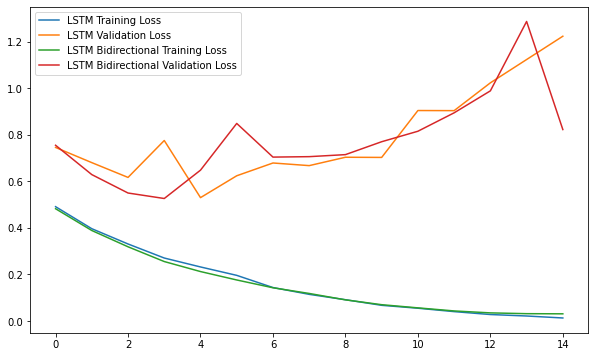

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record_LSTM, label="LSTM Training Loss")
plt.plot(valid_loss_record_LSTM, label="LSTM Validation Loss")
plt.plot(train_loss_record_LSTM_Bidirectional, label="LSTM Bidirectional Training Loss")
plt.plot(valid_loss_record_LSTM_Bidirectional, label="LSTM Bidirectional Validation Loss")
plt.legend()
plt.show()

In [36]:
# A (Model 4)
class model_LSTM_model4(nn.Module):
    def __init__(self):
        super(model_LSTM_model4, self).__init__()
        self.emb = nn.Embedding.from_pretrained(txt_field.vocab.vectors, freeze = True) 
        self.rnn = nn.LSTM(
                input_size = 50,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [37]:
# A (Model 4)
from torchtext.vocab import GloVe
embedding_glove = GloVe(name = "6B", dim = 50)
txt_field.build_vocab(train_data, min_freq = 2, vectors = embedding_glove)
#txt_field.vocab.load_vectors("glove.6B.50d")
#pretrained_vectors = txt_field.vocab.vectors
LSTM_model4 = model_LSTM_model4().cuda()

In [32]:
good = txt_field.vocab["good"]
happy = txt_field.vocab["happy"]
france = txt_field.vocab["france"]
germany = txt_field.vocab["germany"]
good_vec = txt_field.vocab.vectors[good]
happy_vec = txt_field.vocab.vectors[happy]
france_vec = txt_field.vocab.vectors[france]
germany_vec = txt_field.vocab.vectors[germany]

print(torch.dist(happy_vec, good_vec, p = 2))
print(torch.dist(france_vec, germany_vec, p = 2))
print(torch.dist(france_vec, happy_vec, p = 2))

tensor(2.7146)
tensor(3.9774)
tensor(6.3060)


In [33]:
# A (Model 4)
n_epochs = 15
val_acc = None
#save_name = 'lstm_model'
save_path = os.path.join(PATH, "lstm_model4")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(LSTM_model4.parameters())
#start training
train_loss_record_LSTM_model4, valid_loss_record_LSTM_model4 = TRAIN(LSTM_model4, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4991, Valid Loss: 0.7929, Train Accuracy: 0.8072, Valid Accuracy: 0.5005
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model4
Epoch [2/15], Train Loss: 0.4260, Valid Loss: 0.7984, Train Accuracy: 0.8181, Valid Accuracy: 0.5415
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model4
Epoch [3/15], Train Loss: 0.3844, Valid Loss: 0.6872, Train Accuracy: 0.8390, Valid Accuracy: 0.6255
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model4
Epoch [4/15], Train Loss: 0.3625, Valid Loss: 0.6061, Train Accuracy: 0.8542, Valid Accuracy: 0.6435
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model4
Epoch [5/15], Train Loss: 0.3434, Valid Loss: 0.8696, Train Accuracy: 0.8588, Valid Accuracy: 0.5695
Epoch [6/15], Train Loss: 0.3479, Valid Loss: 0.5982, Train Accuracy: 0.8566, Valid Accuracy: 0.6570
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model4
Epoch [7/15], Train Loss: 0.3136, Valid Loss: 0.5607, Train Accuracy: 0.8711, Valid Accuracy: 0.7005
Model sa

In [38]:
# A (Model 5)
class model_LSTM_model5(nn.Module):
    def __init__(self):
        super(model_LSTM_model5, self).__init__()
        self.emb = nn.Embedding.from_pretrained(txt_field.vocab.vectors, freeze = False) 
        self.rnn = nn.LSTM(
                input_size = 50,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [39]:
# A (Model 5)
n_epochs = 15
val_acc = None
LSTM_model5 = model_LSTM_model5().cuda()
save_path = os.path.join(PATH, "lstm_model5")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(LSTM_model5.parameters())
#start training
train_loss_record_LSTM_model5, valid_loss_record_LSTM_model5 = TRAIN(LSTM_model5, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

In [36]:
# A (Model 6)
class model_LSTM_model6(nn.Module):
    def __init__(self, random_vector):
        super(model_LSTM_model6, self).__init__()
        self.emb = nn.Embedding.from_pretrained(random_vector, freeze = True) 
        self.rnn = nn.LSTM(
                input_size = 50,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [37]:
# A (Model 6)
random = torch.rand(txt_field.vocab.vectors.shape)
LSTM_model6 = model_LSTM_model6(random).cuda()

In [38]:
# A (Model 6)
n_epochs = 15
val_acc = None
#save_name = 'lstm_model'
save_path = os.path.join(PATH, "lstm_model6")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(LSTM_model6.parameters())
#start training
train_loss_record_LSTM_model6, valid_loss_record_LSTM_model6 = TRAIN(LSTM_model6, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.5049, Valid Loss: 0.9213, Train Accuracy: 0.8072, Valid Accuracy: 0.5000
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model6
Epoch [2/15], Train Loss: 0.4912, Valid Loss: 0.8678, Train Accuracy: 0.8072, Valid Accuracy: 0.5000
Epoch [3/15], Train Loss: 0.4864, Valid Loss: 0.9127, Train Accuracy: 0.8072, Valid Accuracy: 0.5000
Epoch [4/15], Train Loss: 0.4784, Valid Loss: 0.7864, Train Accuracy: 0.8072, Valid Accuracy: 0.5000
Epoch [5/15], Train Loss: 0.4590, Valid Loss: 0.7234, Train Accuracy: 0.8092, Valid Accuracy: 0.5030
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model6
Epoch [6/15], Train Loss: 0.4491, Valid Loss: 0.7372, Train Accuracy: 0.8154, Valid Accuracy: 0.5625
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model6
Epoch [7/15], Train Loss: 0.4358, Valid Loss: 0.6927, Train Accuracy: 0.8222, Valid Accuracy: 0.6095
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model6
Epoch [8/15], Train Loss: 0.4207, Valid Loss: 0.6206, Train Accur

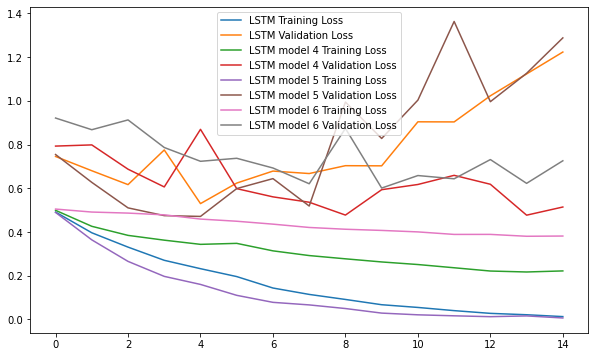

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record_LSTM, label="LSTM Training Loss")
plt.plot(valid_loss_record_LSTM, label="LSTM Validation Loss")
plt.plot(train_loss_record_LSTM_model4, label="LSTM model 4 Training Loss")
plt.plot(valid_loss_record_LSTM_model4, label="LSTM model 4 Validation Loss")
plt.plot(train_loss_record_LSTM_model5, label="LSTM model 5 Training Loss")
plt.plot(valid_loss_record_LSTM_model5, label="LSTM model 5 Validation Loss")
plt.plot(train_loss_record_LSTM_model6, label="LSTM model 6 Training Loss")
plt.plot(valid_loss_record_LSTM_model6, label="LSTM model 6 Validation Loss")
plt.legend()
plt.show()

In [40]:
# B (Model 7)
import math
class model_LSTM_model7(nn.Module):
    def __init__(self, n_vocab, embedding_dim):
        super(model_LSTM_model7, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.emb.weight = nn.init.xavier_normal_(self.emb.weight) 
        self.rnn = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.rnn.weight_ih_l0 = nn.init.xavier_normal_(self.rnn.weight_ih_l0)
        self.rnn.weight_hh_l0 = nn.init.xavier_normal_(self.rnn.weight_hh_l0)
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        self.linear.weight = nn.init.xavier_normal_(self.linear.weight)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [41]:
# B (Model 7)
n_epochs = 15
val_acc = None
LSTM_model7 = model_LSTM_model7(n_vocab, 50).cuda()
save_path = os.path.join(PATH, "lstm_model7")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(LSTM_model7.parameters())
#start training
train_loss_record_LSTM_model7, valid_loss_record_LSTM_model7 = TRAIN(LSTM_model7, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4571, Valid Loss: 0.5698, Train Accuracy: 0.8093, Valid Accuracy: 0.5480
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model7
Epoch [2/15], Train Loss: 0.2466, Valid Loss: 0.5221, Train Accuracy: 0.8896, Valid Accuracy: 0.7650
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model7
Epoch [3/15], Train Loss: 0.1456, Valid Loss: 0.5066, Train Accuracy: 0.9450, Valid Accuracy: 0.7945
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model7
Epoch [4/15], Train Loss: 0.1025, Valid Loss: 0.6294, Train Accuracy: 0.9646, Valid Accuracy: 0.7785
Epoch [5/15], Train Loss: 0.0617, Valid Loss: 0.5730, Train Accuracy: 0.9807, Valid Accuracy: 0.7980
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model7
Epoch [6/15], Train Loss: 0.0405, Valid Loss: 1.0820, Train Accuracy: 0.9864, Valid Accuracy: 0.7640
Epoch [7/15], Train Loss: 0.0236, Valid Loss: 1.0337, Train Accuracy: 0.9937, Valid Accuracy: 0.7795
Epoch [8/15], Train Loss: 0.0152, Valid Loss: 1.2360, Train Accur

In [42]:
# B (Model 8)
class model_LSTM_model8(nn.Module):
    def __init__(self, n_vocab, embedding_dim):
        super(model_LSTM_model8, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.emb.weight = nn.init.kaiming_normal_(self.emb.weight) 
        self.rnn = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = 64,
                num_layers = 1,
                batch_first=True
        )
        self.rnn.weight_ih_l0 = nn.init.kaiming_normal_(self.rnn.weight_ih_l0)
        self.rnn.weight_hh_l0 = nn.init.kaiming_normal_(self.rnn.weight_hh_l0)
        self.drop = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 1)
        self.linear.weight = nn.init.kaiming_normal_(self.linear.weight)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        text_emb = self.emb(text)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(text_emb)
        outputs = outputs[:, -1, :]
        outputs = self.linear(self.drop(outputs))
        #outputs = self.sigmoid(outputs)
        return outputs

In [43]:
# B (Model 8)
n_epochs = 15
val_acc = None
LSTM_model8 = model_LSTM_model8(n_vocab, 50).cuda()
save_path = os.path.join(PATH, "lstm_model8")
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = Adam(LSTM_model8.parameters())
#start training
train_loss_record_LSTM_model8, valid_loss_record_LSTM_model8 = TRAIN(LSTM_model8, train_iter, valid_iter, n_epochs, criterion, optimizer, val_acc, device, save_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/15], Train Loss: 0.4570, Valid Loss: 0.8071, Train Accuracy: 0.8117, Valid Accuracy: 0.5945
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model8
Epoch [2/15], Train Loss: 0.2855, Valid Loss: 0.5599, Train Accuracy: 0.8826, Valid Accuracy: 0.7270
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model8
Epoch [3/15], Train Loss: 0.1735, Valid Loss: 0.5652, Train Accuracy: 0.9312, Valid Accuracy: 0.7515
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model8
Epoch [4/15], Train Loss: 0.1231, Valid Loss: 0.4925, Train Accuracy: 0.9578, Valid Accuracy: 0.7935
Model saved to gdrive/My Drive/Comp 4211/pa3/lstm_model8
Epoch [5/15], Train Loss: 0.0720, Valid Loss: 0.6441, Train Accuracy: 0.9760, Valid Accuracy: 0.7740
Epoch [6/15], Train Loss: 0.0438, Valid Loss: 0.8908, Train Accuracy: 0.9860, Valid Accuracy: 0.7700
Epoch [7/15], Train Loss: 0.0315, Valid Loss: 0.9455, Train Accuracy: 0.9899, Valid Accuracy: 0.7710
Epoch [8/15], Train Loss: 0.0187, Valid Loss: 0.9906, Train Accur

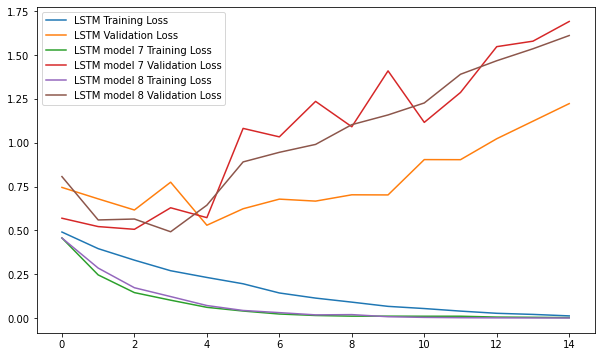

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record_LSTM, label="LSTM Training Loss")
plt.plot(valid_loss_record_LSTM, label="LSTM Validation Loss")
plt.plot(train_loss_record_LSTM_model7, label="LSTM model 7 Training Loss")
plt.plot(valid_loss_record_LSTM_model7, label="LSTM model 7 Validation Loss")
plt.plot(train_loss_record_LSTM_model8, label="LSTM model 8 Training Loss")
plt.plot(valid_loss_record_LSTM_model8, label="LSTM model 8 Validation Loss")
plt.legend()
plt.show()

In [40]:
model_best = LSTM_model5.to(device)
optimizer = Adam(model_best.parameters())
save_path = os.path.join(PATH, "lstm_model5")
best_val_acc = load_checkpoint(save_path, model_best, optimizer)

# make splits for data
train_data, test_data = TabularDataset.splits(path = PATH, train = "train_train.csv", test = "test.csv", format = "csv", 
                                  fields=[("label", label_field), ("text", txt_field)], skip_header = True)

# build the vocabulary on the training set only, 
txt_field.build_vocab(train_data, min_freq = 2) 
#txt_field.build_vocab(valid_data, min_freq = 2)
#label_field.build_vocab(train)

# make iterator for splits
train_iter, test_iter = BucketIterator.splits((train_data, test_data), batch_size = 64, sort_key = lambda x: len(x.text), sort_within_batch = True, shuffle = False)

model_best.eval()
pred = []
#pred = np.empty(0)
with torch.no_grad():
  for b in test_iter:
    text, text_len = b.text
    input = text
    input = input.to(device)
    output = model_best(input)
    output = torch.squeeze(output, 1)
    output = output.cpu().detach().numpy()
    pred = np.concatenate((pred, output))
  pred[pred > 0.5] = 1
  pred[pred <= 0.5] = 0
for i in range(2000):
  test.iloc[i, 0] = pred[i]

Model loaded from gdrive/My Drive/Comp 4211/pa3/lstm_model5, with val accuracy: 0.8160000443458557


/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} cl

In [41]:
p1_path = os.path.join(PATH, "pred.csv")
test.to_csv(p1_path, header = True, index = False)